In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from binance.client import Client
import copy
from pyti.exponential_moving_average import exponential_moving_average as ema
from pyti.bollinger_bands import upper_bollinger_band as ubb
from pyti.bollinger_bands import middle_bollinger_band as mbb
from pyti.bollinger_bands import lower_bollinger_band as lbb
from pyti.relative_strength_index import relative_strength_index as rsi


%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense,LSTM,GRU
import keras

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from keras import backend as K

In [7]:
### METHOD FOR PULLING OHLCV DATA FROM API ###

def get_binance_klines(period='4h'):

  binance_keys = {
      'api_key': "TMu6CGy4SXCHDji8VHexZ18vOQYbrIfQo86hz0EOPpyzhBRIl4wZ1ivmmbEul2tu",
      'api_secret':"x2pzaVdcB36TFEmcnMhJvir6o0qpXJ8foL9LGWAtCpHFcJCfdiah2toJCg7hJl4E"
  }

  client = Client(binance_keys['api_key'],binance_keys['api_secret'])

  if period == '15m':
    return client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_15MINUTE,"1 Aug, 2017")

  if period == '4h':
    return client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_4HOUR,"1 Aug, 2017")

  if period == '12h':
    return client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_12HOUR,"1 Aug, 2017")

  if period == '6h':
    return client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_6HOUR,"1 Aug, 2017")

  if period == '1d':
    return client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1DAY,"1 Aug, 2017")

  return None



### GENERATE ADDITIONAL TECHNICAL INDICATORS FROM THE OPENING PRICE ###
### TECHNICAL INDICATORS: 
#### EMAs: EXPONENTIAL MOVING AVERAGES FOR VARIOUS PERIODS (5-200)
#### BOLLINGER BANDS: UPPER, MIDDLE, LOWER BOLLINGER BAND AND BAND BREADTH
#### MACD: MOVING AVERAGE CONVERGENCE DIVERGENCE
#### RSI: RELATIVE STRENGTH INDEX 

def get_data(klines):
    x = copy.deepcopy(pd.DataFrame(klines)[[1]])
    x.rename(columns={1:"Open"},inplace=True)
    for col in x.columns:
        x[col] = x[col].astype(float)
    
    y_high = copy.deepcopy(pd.DataFrame(klines)[[2]])
    y_high.rename(columns={2:"High"},inplace=True)
    for col in y_high.columns:
        y_high[col] = y_high[col].astype(float)
    
    y_low = copy.deepcopy(pd.DataFrame(klines)[[3]])
    y_low.rename(columns={3:"Low"},inplace=True)
    for col in y_low.columns:
        y_low[col] = y_low[col].astype(float)
    
    y_close = copy.deepcopy(pd.DataFrame(klines)[[4]])
    y_close.rename(columns={4:"Close"},inplace=True)
    for col in y_close.columns:
        y_close[col] = y_close[col].astype(float)
    
    closes = [elem[0] for elem in y_close.values]
    opens = [elem for elem in x['Open'].values]
    diff = [elem[0]-elem[1] for elem in zip(closes,opens)]
    y_status = [1 if elem>=0 else 0 for elem in diff]

    x['low_bollinger'] = lbb(x['Open'].tolist(),20)
    x['high_bollinger'] = ubb(x['Open'].tolist(),20)
    x['band_breadth'] = x['high_bollinger'] - x['low_bollinger']
    x['middle_bollinger'] = mbb(x['Open'].tolist(),20)

    x['rsi'] = rsi(x['Open'].tolist(),20)

    x['ema_5'] = ema(x['Open'].tolist(),6)
    x['ema_10'] = ema(x['Open'].tolist(),10)
    x['ema_15'] = ema(x['Open'].tolist(),10)
    x['ema_20'] = ema(x['Open'].tolist(),10)
    x['ema_25'] = ema(x['Open'].tolist(),10)
    x['ema_30'] = ema(x['Open'].tolist(),10)
    x['ema_35'] = ema(x['Open'].tolist(),10)
    x['ema_40'] = ema(x['Open'].tolist(),10)
    x['ema_45'] = ema(x['Open'].tolist(),10)
    x['ema_50'] = ema(x['Open'].tolist(),10)
    x['ema_60'] = ema(x['Open'].tolist(),10)
    x['ema_70'] = ema(x['Open'].tolist(),10)
    x['ema_80'] = ema(x['Open'].tolist(),10)
    x['ema_90'] = ema(x['Open'].tolist(),10)
    x['ema_100'] = ema(x['Open'].tolist(),100)
    x['ema_200'] = ema(x['Open'].tolist(),200)
    
    x['macd_line'] = ema(x['Open'].tolist(),12) - ema(x['Open'].tolist(),26)
    x['macd_signal'] = ema(x['macd_line'].tolist(),9)
    x['macd_histogram'] = x['macd_line'] - x['macd_signal']

    x['fast_macd_line'] = ema(x['Open'].tolist(),5) - ema(x['Open'].tolist(),35)
    x['fast_macd_signal'] = ema(x['fast_macd_line'].tolist(),5)
    x['fast_macd_histogram'] = x['fast_macd_line'] - x['fast_macd_signal']

    del x['Open']

    x = x[200:]
    y_close = y_close[200:]
    y_high = y_high[200:]
    y_low = y_low[200:]
    y_status = y_status[200:]
    x = x.reset_index(drop=True)
    
    #x,y_close,y_low,y_high = np.array(x),np.array(y_close),np.array(y_low),np.array(y_high)
    
    return x,y_close,y_low,y_high,y_status



# ### FOR CLASSIFICATION TASK, WE USE CANDLE TYPE AS LABELS ###
# ### SPLIT INPUTS AND LABELS INTO TRAIN/TEST SETS ###
# X_train, X_test, Y_train, Y_test = train_test_split(x, y_status, test_size=0.05, shuffle=False)
# X_train,X_test, Y_train, Y_test = np.array(X_train),np.array(X_test),np.array(Y_train),np.array(Y_test)

# ### SCALE DATA ###
# input_scaler = StandardScaler()
# X_train_std = input_scaler.fit_transform(X_train) 
# X_test_std = input_scaler.transform(X_test)

# #target_scaler = StandardScaler()
# #Y_train_std = target_scaler.fit_transform(Y_train)
# #Y_test_std = target_scaler.transform(Y_test)

# ### COMPRESS DATA ###
# input_pca = PCA(n_components=3)
# X_train_pca = input_pca.fit_transform(X_train_std)
# X_test_pca = input_pca.transform(X_test_std)


# ### FOR REGRESSION TASK, WE USE CLOSE PRICE AS LABELS ###

# ### SPLIT INPUTS AND LABELS INTO TRAIN/TEST SETS ###
# X_train, X_test, Y_train, Y_test = train_test_split(x, y_close, test_size=0.05, shuffle=False)
# X_train,X_test, Y_train, Y_test = np.array(X_train),np.array(X_test),np.array(Y_train),np.array(Y_test)

# ### SCALE DATA ###
# input_scaler = StandardScaler()
# X_train_std = input_scaler.fit_transform(X_train) 
# X_test_std = input_scaler.transform(X_test)

# target_scaler = StandardScaler()
# Y_train_std = target_scaler.fit_transform(Y_train)
# Y_test_std = target_scaler.transform(Y_test)

# ### COMPRESS DATA ###
# input_pca = PCA(n_components=5)
# X_train_pca = input_pca.fit_transform(X_train_std)
# X_test_pca = input_pca.transform(X_test_std)

In [8]:
### PULL KLINE DATA USING API ###
### NOTE:SUBJECT TO API LIMITS, USE SPARINGLY ###
klines = get_binance_klines('1d')

### GET INPUTS AND LABELS FOR ML MODELS ###
### INPUT - INDICATORS(BOLLINGER BANDS, EMAs, RSI, MACD) CALCULATED ON OPEN PRICE
### LABEL - LOW PRICE / HIGH PRICE / CLOSE PRICE / CANDLE TYPE
x,y_close,y_low,y_high,y_status = get_data(klines)



In [14]:
### CREATE CUSTOM LOSS FUCNTION(RMSE) ###
### FOR USE AS EVALUATION METRIC FOR ALL REGRESSION TASKS ###
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 


In [15]:
### CONVERT TRAINING AND TEST DATA INTO TIME-SERIES DATA ###
### NECESSARY FOR TRAINING RECURRENT NEURAL NETWORKS ###

def convert_to_timeseries(X_train,X_test,Y_train,Y_test,lookback=10):
    
  x_train = list()
  x_test = list()
  #lookback = 6

  for j in range(np.shape(X_train)[0]-lookback):
    x_train.append(list())
    for i in range(lookback):
      x_train[j].append(X_train[i+j])

  for j in range(np.shape(X_test)[0]-lookback):
    x_test.append(list())
    for i in range(lookback):
      x_test[j].append(X_test[i+j])


  x_train, x_test = np.array(x_train), np.array(x_test)
  #x_train, x_test = np.reshape(x_train,(np.shape(x_train)[0],np.shape(x_train)[1],1)),np.reshape(x_test,(np.shape(x_test)[0],np.shape(x_test)[1],1))

  y_train, y_test = np.array(Y_train)[lookback-1:-1], np.array(Y_test)[lookback-1:-1]

  # np.shape(x_train), np.shape(y_train), np.shape(x_test), np.shape(y_test)

  return x_train,x_test, y_train, y_test


In [28]:
X_train,X_test,Y_train,Y_test = train_test_split(x,y_close,test_size=0.1,shuffle=False)

convert_to_timeseries(X_train,X_test,Y_train,Y_test,lookback=30)

KeyError: 0

In [5]:
# ### MODEL 2 - LSTM RECURRENT NEURAL NETWORK ###

# ### METHOD TO CREATE LSTM RNN ###
# def create_lstm_nn(input_shape = np.shape(x_train)[1:],units=100,loss=root_mean_squared_error,optimizer='adam',activation=None,recurrent_activation=None,use_bias=True,
#                     kernel_initializer='zeros',recurrent_initializer='zeros',bias_initializer='zeros',
#                     kernel_regularizer=None,recurrent_regularizer=None,bias_regularizer=None,activity_regularizer=None,
#                           kernel_constraint=None,bias_constraint=None,recurrent_constraint=None,dropout=0.0,recurrent_dropout=0.0,unit_forget_bias=True):
#   lstm_nn = Sequential()

#   lstm_nn.add(LSTM(units = units, activation=activation, recurrent_activation=recurrent_activation,use_bias=use_bias,
#               kernel_initializer=kernel_initializer, recurrent_initializer=recurrent_initializer, bias_initializer=bias_initializer,
#               unit_forget_bias=unit_forget_bias,kernel_regularizer=kernel_regularizer, recurrent_regularizer=recurrent_regularizer, bias_regularizer=bias_regularizer, activity_regularizer=activity_regularizer,
#               kernel_constraint=kernel_constraint,recurrent_constraint=recurrent_constraint, bias_constraint=bias_constraint, dropout=dropout, recurrent_dropout=recurrent_dropout,
#               implementation=2,return_sequences=True, return_state=False, go_backwards=False, 
#                   stateful=False, unroll=False,input_shape=input_shape))

# #   lstm_nn.add(LSTM(units = units//2, activation=activation, recurrent_activation=recurrent_activation,use_bias=use_bias,
# #               kernel_initializer=kernel_initializer, recurrent_initializer=recurrent_initializer, bias_initializer=bias_initializer,
# #               unit_forget_bias=unit_forget_bias,kernel_regularizer=kernel_regularizer, recurrent_regularizer=recurrent_regularizer, bias_regularizer=bias_regularizer, activity_regularizer=activity_regularizer,
# #               kernel_constraint=kernel_constraint,recurrent_constraint=recurrent_constraint, bias_constraint=bias_constraint, dropout=dropout, recurrent_dropout=recurrent_dropout,
# #               implementation=2,return_sequences=True, return_state=False, go_backwards=False, 
# #                   stateful=False, unroll=False))
  
# #   lstm_nn.add(LSTM(units = units//4, activation=activation, recurrent_activation=recurrent_activation,use_bias=use_bias,
# #               kernel_initializer=kernel_initializer, recurrent_initializer=recurrent_initializer, bias_initializer=bias_initializer,
# #               unit_forget_bias=unit_forget_bias,kernel_regularizer=kernel_regularizer, recurrent_regularizer=recurrent_regularizer, bias_regularizer=bias_regularizer, activity_regularizer=activity_regularizer,
# #               kernel_constraint=kernel_constraint,recurrent_constraint=recurrent_constraint, bias_constraint=bias_constraint, dropout=dropout, recurrent_dropout=recurrent_dropout,
# #               implementation=2,return_sequences=False, return_state=False, go_backwards=False, 
# #                   stateful=False, unroll=False))

# #   lstm_nn.add(Dense(units=units//8,activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,
# #                           kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,
# #                           kernel_constraint=kernel_constraint,bias_constraint=bias_constraint))

#   lstm_nn.add(Dense(units=1,activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,
#                           kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,
#                           kernel_constraint=kernel_constraint,bias_constraint=bias_constraint))

#   lstm_nn.compile(loss=loss,optimizer=optimizer)

#   return lstm_nn

### HYPER-PARAMETER TUNING ###

### TUNABLE HYPERPARAMETERS ###
### UNITS, OPTIMIZER, ACTIVATION, RECURRENT ACTIVATION, USE_BIAS, INITIALIZER(KERNEL,RECURRENT,BIAS), REGULARIZER(KERNEL,RECURRENT,BIAS),
### CONSTRAINTS(KERNEl,RECURRENT,BIAS), DROPOUT, RECURRENT DROPOUT, UNIT_FORGET_BIAS


# ### CREATE KerasRegressor Object ###
# lstm_regressor = KerasRegressor(build_fn=create_lstm_nn,verbose=0)

# ### CREATE PARAMETER GRID FOR HYPERPARAMETER TUNING ###
# lstm_param_grid = {
#     'optimizer':['adam',
#                      'adamax',
#                      'nadam',
#                      'adagrad'
#                     ],
#     'activation':[None,'tanh'],
#     'recurrent_activation': [None,'sigmoid'],
#     'use_bias':[True,False],
#     'kernel_initializer':['zeros','glorot_uniform'],
#     'recurrent_initializer':['orthogonal','glorot_uniform'],
#     'bias_initializer':['glorot_uniform'],
#     'kernel_regularizer':[None],
#     'bias_regularizer':[None],
#     'recurrent_regularizer':[None],
#     'dropout':[0.0],
#     'recurrent_dropout':[0.0],
#     'unit_forget_bias':[True,False],
#     'units':[50,500],
#     'batch_size':[32],
#     'epochs':[5]
# }

# ### CREATE GridSearchCV Object ###
# lstm_grid = GridSearchCV(estimator=lstm_regressor,
#                   param_grid=lstm_param_grid,
#                   scoring=None,
#                   n_jobs=-1,
#                   cv=2,
#                   refit=True,
#                  verbose=1
#                  )

# lstm_grid = lstm_grid.fit(x_train,y_train)

# ### BEST CANDIDATE OBTAINED AFTER GRID SEARCH OVER PARAMETER SEARCH SPACE ###
# lstm_grid.best_estimator_,lstm_grid.best_index_,lstm_grid.best_params_,lstm_grid.best_score_

# ### PLOT OF TUNED MODEL PREDICTION VS ACTUAL VALUES ###
# predicted_labels = target_scaler.inverse_transform(lstm_gs.predict(X_test_pca))
# actual_labels = Y_test
# plt.plot(predicted_labels)
# plt.plot(actual_labels)
# plt.title('Tuned LSTM Model Prediction')
# plt.ylabel('BTC Price (In USD)')
# plt.xlabel('Time Periods')
# plt.legend(['Predicted','Actual'],loc='best')
# plt.show()

In [26]:
# input_data = y_close.values[:-10]
# targets = y_close.values[10:]
# dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
#     input_data, targets, sequence_length=10)
# for batch in dataset:
#   inputs, targets = batch
#   assert np.array_equal(inputs[0], y_close.values[:10])  # First sequence: steps [0-9]
#   assert np.array_equal(targets[0], y_close.values[10])  # Corresponding target: step 10
#   break

In [17]:
### METHOD TO CREATE GRU NETWORK ###
def create_gru_nn(units=500,loss=root_mean_squared_error,optimizer='adam',activation=None,recurrent_activation=None,use_bias=True,
                    kernel_initializer='zeros',recurrent_initializer='zeros',bias_initializer='zeros',
                    kernel_regularizer=None,recurrent_regularizer=None,bias_regularizer=None,activity_regularizer=None,
                          kernel_constraint=None,bias_constraint=None,recurrent_constraint=None,dropout=0.0,recurrent_dropout=0.0):
  gru_nn = Sequential()

  gru_nn.add(GRU(units = units, activation=activation, recurrent_activation=recurrent_activation,use_bias=use_bias,
              kernel_initializer=kernel_initializer, recurrent_initializer=recurrent_initializer, bias_initializer=bias_initializer,
              kernel_regularizer=kernel_regularizer, recurrent_regularizer=recurrent_regularizer, bias_regularizer=bias_regularizer, activity_regularizer=activity_regularizer,
              kernel_constraint=kernel_constraint,recurrent_constraint=recurrent_constraint, bias_constraint=bias_constraint, dropout=dropout, recurrent_dropout=recurrent_dropout,
              implementation=2,return_sequences=True, return_state=False, go_backwards=False, 
                  stateful=False, unroll=False, reset_after=False))

  gru_nn.add(GRU(units = units//2, activation=activation, recurrent_activation=recurrent_activation,use_bias=use_bias,
              kernel_initializer=kernel_initializer, recurrent_initializer=recurrent_initializer, bias_initializer=bias_initializer,
              kernel_regularizer=kernel_regularizer, recurrent_regularizer=recurrent_regularizer, bias_regularizer=bias_regularizer, activity_regularizer=activity_regularizer,
              kernel_constraint=kernel_constraint,recurrent_constraint=recurrent_constraint, bias_constraint=bias_constraint, dropout=dropout, recurrent_dropout=recurrent_dropout,
              implementation=2,return_sequences=True, return_state=False, go_backwards=False, 
                  stateful=False, unroll=False, reset_after=False))

  gru_nn.add(GRU(units = units//4, activation=activation, recurrent_activation=recurrent_activation,use_bias=use_bias,
              kernel_initializer=kernel_initializer, recurrent_initializer=recurrent_initializer, bias_initializer=bias_initializer,
              kernel_regularizer=kernel_regularizer, recurrent_regularizer=recurrent_regularizer, bias_regularizer=bias_regularizer, activity_regularizer=activity_regularizer,
              kernel_constraint=kernel_constraint,recurrent_constraint=recurrent_constraint, bias_constraint=bias_constraint, dropout=dropout, recurrent_dropout=recurrent_dropout,
              implementation=2,return_sequences=False, return_state=False, go_backwards=False, 
                  stateful=False, unroll=False, reset_after=False))

  gru_nn.add(Dense(units=units//8,activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,
                          kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,
                          kernel_constraint=kernel_constraint,bias_constraint=bias_constraint))

  gru_nn.add(Dense(units=1,activation=activation,use_bias=use_bias,kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,
                          kernel_regularizer=kernel_regularizer,bias_regularizer=bias_regularizer,activity_regularizer=activity_regularizer,
                          kernel_constraint=kernel_constraint,bias_constraint=bias_constraint))

  gru_nn.compile(loss=loss,optimizer=optimizer)

  return gru_nn


In [18]:
### CREATE KerasRegressor MODEL USING PREVIOUS FUNCTION ###
gru_regressor = KerasRegressor(build_fn=create_gru_nn,verbose=1,
                              optimizer=keras.optimizers.Adamax(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
                              units=500,
                              use_bias=True,
                              activation=None,
                              recurrent_activation='sigmoid',
                              kernel_initializer = keras.initializers.glorot_uniform(seed=980),
                              recurrent_initializer = 'orthogonal',
                              bias_initializer = keras.initializers.glorot_uniform(seed=988),
                              kernel_regularizer = None,
                              recurrent_regularizer = None,
                              bias_regularizer = None,
                              activity_regularizer = None,
                              dropout = 0.0,
                              recurrent_dropout = 0.0
                              )

### FIT MODEL TO TRAINING DATA ###
history_gru=gru_regressor.fit(x_train,y_train,epochs=50,shuffle=True,validation_split=0.2)

NameError: name 'x_train' is not defined

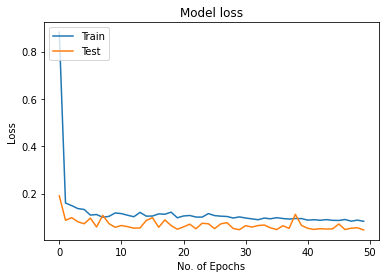

In [ ]:
### PLOT TRAINING AND VALIDATION LOSS AS FUNCTION OF NO. OF EPOCHS###
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('No. of Epochs')
plt.legend(['Train','Test'],loc='upper left')
plt.show()

285/285 [==============================] - 0s 1ms/step


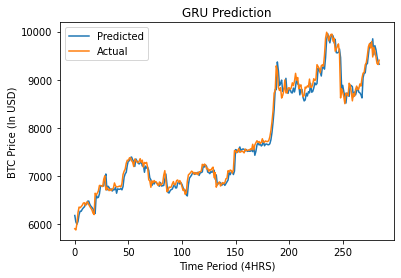

In [ ]:
### PLOT OF MODEL PREDICTED VALUES VS ACTUAL VALUES ###
predicted_labels = target_scaler.inverse_transform(gru_regressor.predict(x_test))
actual_labels = target_scaler.inverse_transform(y_test) 
plt.plot(predicted_labels)
plt.plot(actual_labels)
plt.title('GRU Prediction')
plt.ylabel('BTC Price (In USD)')
plt.xlabel('Time Period (4HRS)')
plt.legend(['Predicted','Actual'],loc='best')
plt.show()